## Рейтинг стран по стоимости недельного отдыха в 4х звёздочном отеле на основе данных сайта [tez-tour.com](https://www.tez-tour.com)

Рейтинг стран по стоимости отдыха с использованием открытого API для подбора туров (https://www.tez-tour.com/article.html?id=7016090) туроператора TEZ TOUR.
 

Использовались следующие параметры подбора тура:
- Один человек
- Вылет из Москвы
- Дата вылета варьируется от сегодняшнего дня плюс две недели
- Длительность отдыха - неделя
- 4х звёздочный отель
- Все возможные варианты размещения (Только завтраки/Всё включено/ и т.д.)

In [1]:
import requests
import pygal
import time

import numpy as np
import pandas as pd

from iso3166 import countries as codes
from urllib.parse import urlparse, parse_qs, urlencode, urlunparse
from pygal.style import RotateStyle
from datetime import datetime, timedelta
from IPython.display import Image

In [2]:
def change_url(url, **kwargs):
    """Изменить query URL"""
    parsed_url = list(urlparse(url))
    query = parse_qs(parsed_url[4])

    for key, value in kwargs.items():
        query[key] = [value]

    parsed_url[4] = urlencode(query, doseq=True)
    return urlunparse(parsed_url)

In [3]:
def get_data(url, retry_count=0):
    """Получить данные"""
    MAX_RETRIES = 10  # Максимальное число попыток
    pause_time = 10  # Время паузы [с]
    try:
        return requests.get(url).json()
    except:
        if retry_count == MAX_RETRIES:
            return False
        print("Cant get data, retry_count=" + str(retry_count) + " new try in 10s")
        time.sleep(pause_time)
        return get_data(url, retry_count + 1)

In [4]:
def search_cities(url):
    """Поиск туров по городам в пределах одной страны"""
    cities = []
    tour_counter = 0
    tariff_search = get_data(url)
    while int(tariff_search['info'][1][1]) > 0:
        # API отдаёт результаты по 100 штук упорядоченные по возрастанию цены,
        # чтобы получать остальные, нужно повышать минимальную цену.
        for result in tariff_search['data']:
            tour_counter += 1
            city_name = result[5][0]
            price = int(result[10]['total'])
            for city in cities:
                if city['name'] == city_name:
                    # Город уже записали, добавим новую цену
                    city['prices'].append(price)
                    city['num_of_tours'] += 1
                    break
            else:
                # Город встречается впервые
                cities.append({'name': city_name,
                               'prices': [price],
                               'num_of_tours': 0})

        last_price = price + 1
        url = change_url(url, **{'priceMin': str(last_price)})  # Повысили минимальную цену
        tariff_search = get_data(url)

    for city in cities:
        # Расчитаем среднюю цену для каждого города
        city['mean_price'] = np.round(np.mean(np.array(city['prices'])), 0)

    return cities, tour_counter

In [5]:
def search_countries(url, countries):
    """Поиск туров по странам"""
    for country in countries:
        url = change_url(url, **{'countryId': country['countryId'], 'priceMin': '0'})
        tariff_search = get_data(url)

        if not tariff_search:
            country['num_of_tours'] = 0
            continue
        elif not tariff_search['success']:
            # Неудачный запрос
            country['num_of_tours'] = 0
        elif int(tariff_search['info'][1][1]) == 0:
            # Нет результатов
            country['num_of_tours'] = 0
        else:
            # Всё в порядке
            country['cities'], country['num_of_tours'] = search_cities(url)
            country['mean_price'] = np.mean(np.array([city['mean_price'] for city in country['cities']]))
            country['mean_price'] = int(np.round(country['mean_price'], 0))
        
        print(str(country['name']) + '\t' + str(country['num_of_tours']))
    # Вернём только страны с результатами
    return [country for country in countries if country['num_of_tours'] > 0]

In [6]:
def fix_names(countries):
    """Некоторые исправления имён стран и городов"""

    for country in countries:
        if country['name'].find("(") > 0:
            country['name'] = country['name'][:country['name'].find("(")].strip()
        country['name'] = country['name'].capitalize()
        
        for city in country['cities']:
            if city['name'].find("(") > 0:
                city['name'] = city['name'][:city['name'].find("(")].strip()
    
    for country in countries:
    # Некоторые названия стран нужно исправить, чтобы получить коды стран (для построения карты)
        if country['name'] == 'Dominicana':
            country['name'] = 'Dominican Republic'
        if country['name'] == 'Uae':
            country['name'] = 'United Arab Emirates'
        if country['name'] == 'Czech republic':
            country['name'] = 'Czechia'
        if country['name'] == 'Russia':
            country['name'] = 'Russian Federation'
        if country['name'] == 'Шри ланка':
            country['name'] = 'Sri Lanka'
        # Получаем коды стран
        country['code'] = codes.get(country['name'])[1].lower()
    
    return countries

In [7]:
def mk_rank_table(countries):
    """Построить рейтинговую таблицу стран"""
    rank = pd.DataFrame({'Country name': [counry['name'] for counry in countries],
                         'Country code': [country['code'] for country in countries],
                         'Mean price $': [country['mean_price'] for country in countries],
                         'Number of tours': [country['num_of_tours'] for country in countries]})

    rank.sort_values('Mean price $', inplace=True, ascending=False)
    rank.reset_index(drop=True, inplace=True)
    
    return rank

In [8]:
def mk_dist(countries, title=""):
    """Нарисовать распределение по числу туров"""
    hist = pygal.Bar()
    hist.title = title
    hist.x_title = "Самые дешёвые города каждой из стран рейтинга"
    hist.y_title = "Число туров"
    
    for country in countries:
        country['cities'] = sorted(country['cities'], key = lambda city : city['mean_price'])

    countries = sorted(countries, key = lambda country: country['cities'][0]['num_of_tours'])
    
    for country in countries:
        if country['mean_price'] < 1500:
            hist.add(country['cities'][0]['name'], country['cities'][0]['num_of_tours'])
    
    return hist

In [9]:
def mk_world_map(countries, title=""):
    """Нарисовать карту"""
    my_style = RotateStyle('#FF3333', step=10)
    wm = pygal.maps.world.World(style=my_style)
    wm.force_uri_protocol = 'http'
    wm.title = title

    wm.add('> 2000 $', {country['code']: country['mean_price'] for country in countries if country['mean_price'] > 2000})
    wm.add('2000 - 5000 $', {country['code']: country['mean_price'] for country in countries if 2000 > country['mean_price'] > 1500})
    wm.add('1500 - 1000 $', {country['code']: country['mean_price'] for country in countries if 1500 > country['mean_price'] > 1000})
    wm.add('< 1000 $', {country['code']: country['mean_price'] for country in countries if country['mean_price'] < 1000})
    
    return wm

In [10]:
# Общий справочник
common_data_url = 'http://search.tez-tour.com/tariffsearch/refs?locale=en&formatResult=true&xml=false&formatResult=true'
common_data = get_data(common_data_url)

countries = common_data['countries']  # Страны

# Справочник стран и городов, для которых должен работать подбор
calc_types_url = 'http://search.tez-tour.com/toursearch/getCalcTypes?xml=false&formatResult=true'
calc_types = get_data(calc_types_url)['calcByTariffs']  
calc_types = set([t['arrCountry'] for t in calc_types])  # Оставим только страны

countries = [country for country in countries if country['countryId'] in calc_types]

In [11]:
# URL для подбора туров tariffsearch
tariff_search_url = 'http://search.tez-tour.com/tariffsearch/getResult?\
accommodationId=1&\
after=01.08.2017&\
before=01.08.2017&\
cityId=345&\
countryId=1104&\
currency=5561&\
formatResult=true&\
hotelClassBetter=false&\
hotelClassId=2568&\
hotelInStop=false&\
locale=en&\
nightsMin=7&\
nightsMax=7&\
noTicketsTo=false&\
noTicketsFrom=false&\
onlineConfirmFlag=false&\
priceMin=0&\
priceMax=1500000&\
rAndBBetter=true&\
rAndBId=15350&\
recommendedFlag=false&\
salePrivateFlag=false&\
searchTypeId=3&\
specialInStop=false&\
tourType=1&\
version=2'

tariff_search = urlparse(tariff_search_url)
tariff_query = parse_qs(tariff_search.query)

In [12]:
before = datetime.now()
after = before + timedelta(days=14)

before = before.strftime("%d.%m.%y")
after = after.strftime("%d.%m.%y")

tariff_search_url = change_url(tariff_search_url, **{'after': after, 'before': before})

In [ ]:
countries = search_countries(tariff_search_url, countries)

In [14]:
countries = fix_names(countries)

In [15]:
rank = mk_rank_table(countries)
rank

,Country code,Country name,Mean price $,Number of tours
0,sc,Seychelles,3048,730
1,mu,Mauritius,2620,336
2,mv,Maldives,2481,135
3,mx,Mexico,2442,48
4,lk,Sri lanka,1855,2410
5,cn,China,1743,50
6,ae,United Arab Emirates,1665,918
7,id,Indonesia,1653,904
8,ee,Estonia,1608,423
9,it,Italy,1483,2621


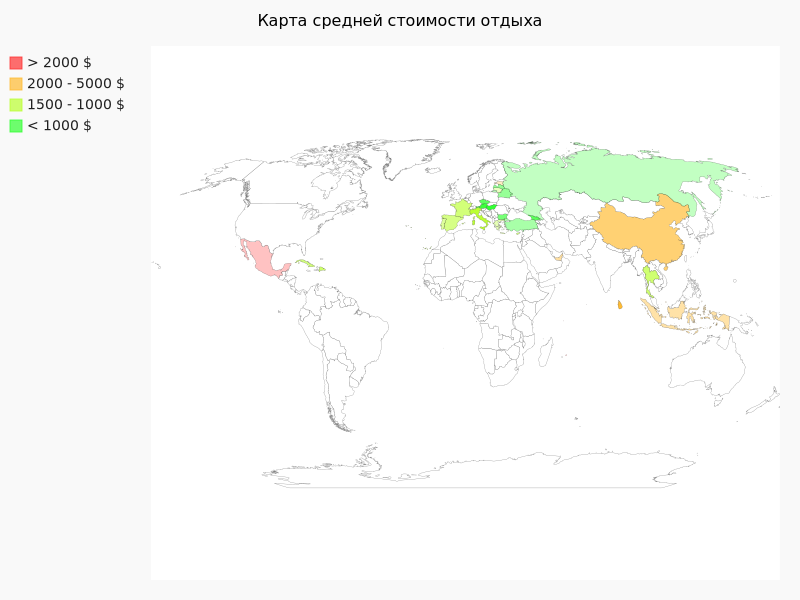

In [16]:
wm = mk_world_map(countries, "Карта средней стоимости отдыха")
wm.render_to_png("images/map.png")
Image(filename="images/map.png", width=1280, height=720)

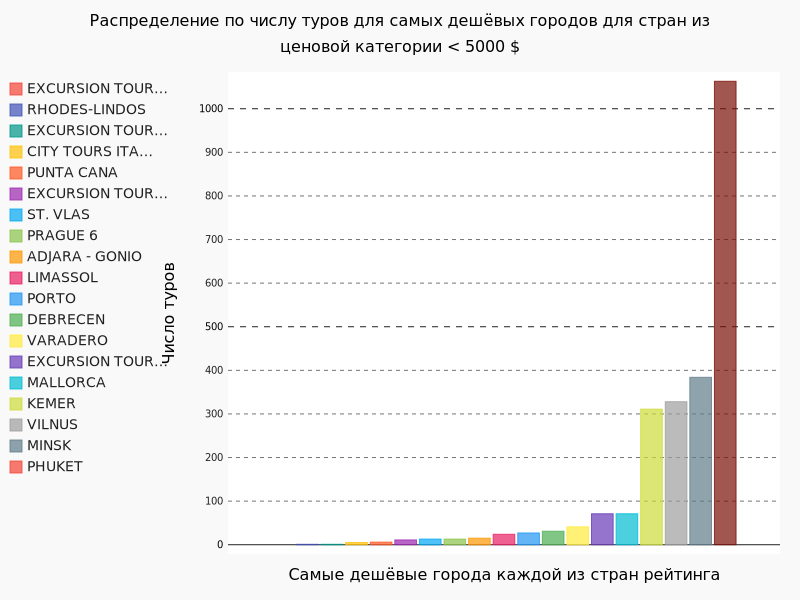

In [17]:
dist = mk_dist(countries, "Распределение по числу туров для самых дешёвых городов для стран из ценовой категории < 5000 $")
dist.render_to_png("images/hist.png")
Image(filename="images/hist.png", width=1280, height=720)